In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# Load images from folder, preprocess, and convert to grayscale
folder_path = "../Images"
images = []
for filename in os.listdir(folder_path):
    img = cv2.imread(os.path.join(folder_path, filename))
    #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray_resized = cv2.resize(img, (256, 256))
    images.append(img_gray_resized/255.0)

# Convert images to PyTorch tensor
images_tensor = torch.tensor(images, dtype=torch.float32).permute(0,3,1,2) 



C:\Users\nmadali\AppData\Local\Temp\ipykernel_11312\3410138171.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  images_tensor = torch.tensor(images, dtype=torch.float32).permute(0,3,1,2)


In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # (N, 1, 256, 256) -> (N, 16, 128, 128)
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (N, 16, 128, 128) -> (N, 32, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (N, 32, 64, 64) -> (N, 64, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # (N, 64, 32, 32) -> (N, 128, 16, 16)
            nn.ReLU(True),
        )
        # Latent space
        self.latent_space = nn.Linear(128 * 16 * 16, 256)
        # Decoder
        self.decoder_mlp= nn.Sequential(
            nn.Linear(256, 128 * 16 * 16),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # (N, 128, 16, 16) -> (N, 64, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # (N, 64, 32, 32) -> (N, 32, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (N, 32, 64, 64) -> (N, 16, 128, 128)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # (N, 16, 128, 128) -> (N, 1, 256, 256)
            
        )
    def encoding(self,x):
        x = self.encoder(x)
        
        x = x.reshape(x.size(0), -1)  # flatten the tensor
        return self.latent_space(x)
    def decoding(self,x):
        x=self.decoder_mlp(x).view(x.size(0), 128, 16, 16)
        x = self.decoder(x)  # reshape the tensor
        return x
    def forward(self, x):
        x = self.encoder(x)
        
        x = x.reshape(x.size(0), -1)  # flatten the tensor
        x = self.latent_space(x)
        x=self.decoder_mlp(x).view(x.size(0), 128, 16, 16)
        x = self.decoder(x)  # reshape the tensor
        return x


In [4]:
# Initialize model
model = Autoencoder()

In [5]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training
num_epochs = 1000
train_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    optimizer.zero_grad()
    outputs = model(images_tensor)
    loss = criterion(outputs, images_tensor)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    train_losses.append(running_loss)
    if epoch %100==0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss))



Epoch [1/1000], Loss: 0.0753
Epoch [101/1000], Loss: 0.0071
Epoch [201/1000], Loss: 0.0034
Epoch [301/1000], Loss: 0.0023
Epoch [401/1000], Loss: 0.0019
Epoch [501/1000], Loss: 0.0015
Epoch [601/1000], Loss: 0.0014
Epoch [701/1000], Loss: 0.0011
Epoch [801/1000], Loss: 0.0011
Epoch [901/1000], Loss: 0.0010


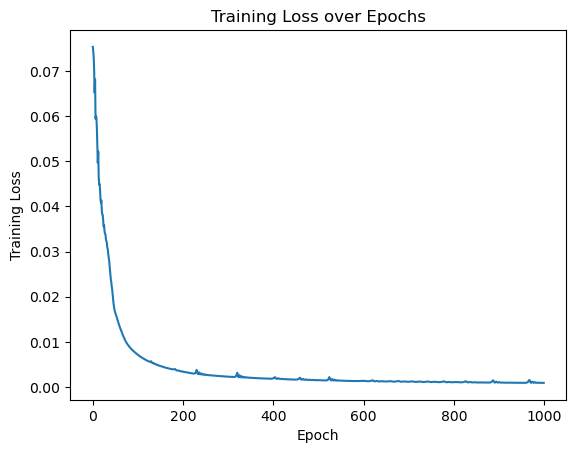

In [7]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

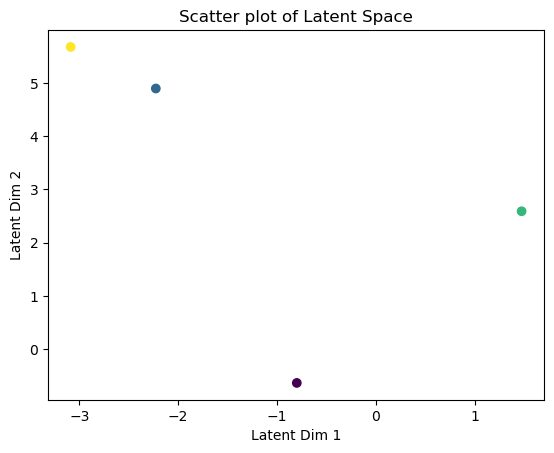

In [8]:
# Scatter plot of latent space
with torch.no_grad():
    latent_points = model.encoding(images_tensor).numpy()
plt.scatter(latent_points[:, 0], latent_points[:, 1],c=np.arange(len(images)))
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Scatter plot of Latent Space')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


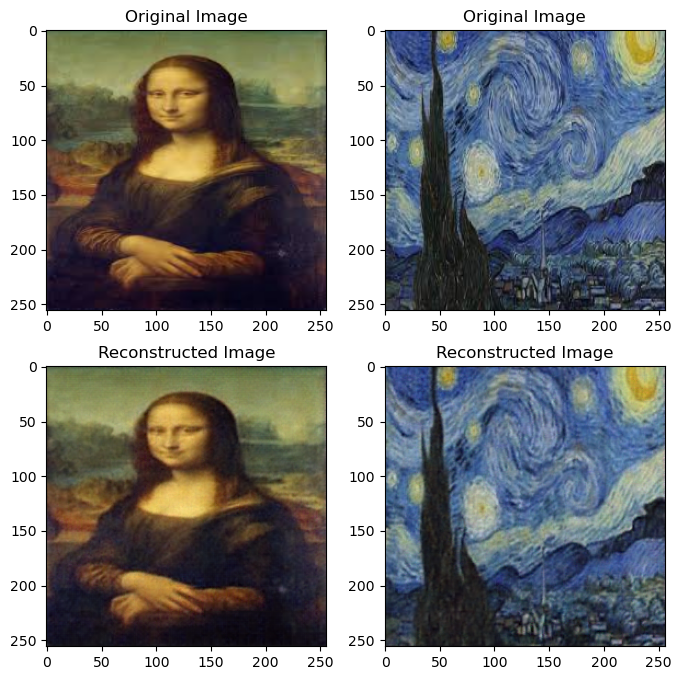

In [9]:
# Reconstruction of selected images
selected_images = images_tensor[:2]
with torch.no_grad():
    reconstructed_images = model(selected_images).permute(0,2,3,1).numpy()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    axes[0, i].imshow(np.flip(selected_images.permute(0,2,3,1)[i].numpy(),-1))
    axes[0, i].set_title('Original Image')
    axes[1, i].imshow(np.flip(reconstructed_images[i],-1))
    axes[1, i].set_title('Reconstructed Image')
plt.show()

In [10]:
u,v=0,3
# Interpolation between two selected latent points
latent1 = model.encoding(images_tensor[u].unsqueeze(0)).detach().numpy()
latent2 = model.encoding(images_tensor[v].unsqueeze(0)).detach().numpy()
interpolation_points = np.zeros((10, 256))
for i in range(10):
    interpolation_points[i] = latent1 + (latent2 - latent1) * i / 9


In [11]:
with torch.no_grad():
    interpolated_images = model.decoding(torch.tensor(interpolation_points).float()).clip(0,1).permute(0,2,3,1).numpy()

In [12]:
# Plot the decoded images
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    axes[i].imshow(np.flip(interpolated_images[i],-1))
    axes[i].axis('off')
plt.show()